# Getting started on smFISH

I took a stab at getting started trying to detect spots in smFISH data. Don't know if it's useful, but it may be a start. I have previously written a bunch of code to analyze MS2 data, and this has a spot-finding component (which I based on the smFISH paper...I think?). The strategy is to first do some crude thing (like thresholding or finding local maxima) to make a first guess at where spots might be, and then to use gaussian fitting to those candidates. By filtering on the parameters of the fit (intensity and widths), we hope to identify true spots.

As always, start by importing some useful packages. I don't have a list of dependences; I would just run this, let the error message tell you what package you're missing, install it in terminal...and repeat until hopefully the whole cell executes without errors, meaning you've installed everything.

In [1]:
# Import some public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

I wrote a couple sets of functions (modules) that I will send you. Put these two .py files (imagep.py and fitting.py) in a folder, assign the path to that folder to the __folder__ object:

In [2]:
folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin'

In [3]:
# Import my modules and some functions from them.
import sys
sys.path.append(folder)
import imagep as imp
import fitting as fit
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi
from fitting import fitgaussian3d

Import your czi file as the object __stack__. To make life easier, I think it's wise to start with a smaller section of the larger image, if only to make computation faster while you're testing stuff out. I'm calling this __tstack__. For the sample image you sent, it's also convenient that this section doesn't contain any of the bright foci (chromosomal transcription sites), just the dots we want to find. Good place to start, anyway.

In [4]:
stack = read_czi('/Users/michaelstadler/Downloads/btd-05.czi', swapaxes=False)
tstack = stack[0,12:,100:200,100:200]

A super useful thing to have is an image viewer. I wrote this __viewer__ function which is decent. Obviously, I encourage you to improve (and share) or customize for your purposes. It just allows you to scroll through slices and also adjust contrast. A couple useful features are that you can click on a spot (click and release, you don't have to hold it) and then use the arrow keys you can scroll over one at a time. Also, you can click the numbers and type them in manually.

In [5]:
viewer(tstack, figsize=6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…

## Taking a stab at spot-finding

I'm not sure how to procede from here. I've put down some ideas to maybe get you started, but it may be that none of it turns out to be the right thing to do. Anyway, I start by doing some filtering to try to bring the spots out. Here I'm using a difference of gaussians (DoG) that is essentially a band-pass filter: it lets features of a certain frequency range through. The filter takes and upper and lower sigma (sigma being the variance of the gaussian distributions...that's not really important). By playing with the sigmas, you change the frequency information that gets through. You really have to just play with it to see what it does. I played with it some, and using values of 1 and 4 seems to do a decent job of keeping spots and getting rid of a lot of other stuff:

In [6]:
big_sigma=4
small_sigma=1
dog = imp.dog_filter(tstack, small_sigma, big_sigma)

# View original (left) and dog filter (right).
viewer([tstack, dog])

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…

Again, I'm really unsure what the right thing to do here is, but here's a stab. To generate initial candidates for spots, you can find local maxima within some window. I wrote this function __peak_local_max_nD__ that will find all peaks that are maxima within a set window. Tweaking the size of the window is of course key--too large and you miss spots that are near each other. For this image, a 3x10x10 pixel window seems like a not terrible starting place.

In [7]:
mask, peaks = imp.peak_local_max_nD(dog, (3,10,10))

The function returns a mask (an image of the same dimensions as the input image except it's all zeros except where the function called peaks) and a list of the peaks. We can take a look at these:

In [8]:
# Peaks is a list of coordinate tuples, each of which is a point in the image.
peaks[:5]

[(0, 0, 77), (0, 1, 99), (0, 2, 5), (0, 3, 15), (0, 6, 35)]

It's always essential so see what happened. You could try looking at the mask and the original in the viewer, but it sucks for multiple reasons:

In [9]:
viewer([dog, mask.astype('bool')*1000], figsize=6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…

Luckily I have a better (I hope) solution. I wrote a function to draw boxes around points. I had to adapt it a little for this, so instead of calling the version of __box_spots__ from the module, I put the modified version here:

In [10]:
def box_spots(stack, coords, max_mult=1.3, halfwidth_xy=5, 
              halfwidth_z=2, linewidth=1, shadows=False):
    """Draw boxes around detected coordinates in an image from a list.
    
    Usage suggestions: Useful with a Z-projection to examine effectiveness
    of spot segmentation. Can also use with very small halfwidths to create
    artificial "dots" representing called spots to overlay on other data,
    e.g. a nuclear mask or a blank matrix of 0s (to examine spot movement
    alone).
    
    Args: 
        stack: ndarray of uint16
            Image stack of dimensions [z,x,y]
        spot_data: list of tuples
            List of coordinate tuples for the boxes to be plotted.
        max_multi: numeric
            Multiplier of maximum value to use for drawing box.
        halfwidth_xy: int
            Halfwidth in pixels of the boxes in xy direction (sides will be 
            2*halfwidth)
        halfwidth_z: int
            Halfwidth of the boxes in z direction(vertical sides will be 
            2*halfwidth)
        linewidth: int
            Width of lines used to draw boxes
        shadows: bool
            Draw "shadows" (dark boxes) in non-boxed z-slices.
        
    Return:
        boxstack: ndarray
            Input image stack with boxes drawn around spots. 
    """
    boxstack = np.copy(stack)
    # uint16 images get screwed up by negative numbers, so reset min to 0.
    if (boxstack.min() < 0):
        boxstack = boxstack - boxstack.min()
    boxstack = boxstack.astype('uint16')
    
    hival = max_mult * boxstack.max()
    if (hival > 65535):
        hival = 65535
    
    
    def drawbox(boxstack, point, halfwidth_xy, halfwidth_z, linewidth, hival, shadows):
        """Draw a box around a point"""
        # Get the bounds of the box.
        z, i, j = point
        z_min = max(0, z - halfwidth_z)
        z_max = min(boxstack.shape[0], z + halfwidth_z + 1)
        i_min = max(0, i - halfwidth_xy)
        i_max = min(boxstack.shape[1], i + halfwidth_xy + 1)
        j_min = max(0, j - halfwidth_xy)
        j_max = min(boxstack.shape[2], j + halfwidth_xy + 1)
        if shadows:
            # Draw shadow boxes in all Z-frames.
            boxstack[:, i_min:i_max, j_min:(j_min + linewidth)] = 0
            boxstack[:, i_min:i_max, (j_max-linewidth):j_max] = 0
            boxstack[:, i_min:(i_min+linewidth), j_min:j_max] = 0
            boxstack[:, (i_max-linewidth):i_max, j_min:j_max] = 0
        # Draw left line.
        boxstack[z_min:z_max, i_min:i_max, j_min:(j_min + linewidth)] = hival     
        # Draw right line. 
        boxstack[z_min:z_max, i_min:i_max, (j_max-linewidth):j_max] = hival
        # Draw top line. 
        boxstack[z_min:z_max, i_min:(i_min+linewidth), j_min:j_max] = hival
        # Draw bottom line.
        boxstack[z_min:z_max, (i_max-linewidth):i_max, j_min:j_max] = hival
    
    # Main.
    for i in range(0, len(coords)):
        point = (np.array(coords[i][0:3]).astype(int))
        drawbox(boxstack, point, halfwidth_xy, halfwidth_z, linewidth, hival, shadows)
    return boxstack  

In [11]:
# Take a look at our first try.
viewer(box_spots(dog, peaks, shadows=False, halfwidth_xy=3, halfwidth_z=0), 6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…

A useful thing to do is to look at projections (max, mean, min, etc.). You can do this easily use the .max(axis=) syntax like so:

In [12]:
# View a maximum projection.
boxed = box_spots(dog, peaks, shadows=False, halfwidth_xy=3, halfwidth_z=0)
viewer(boxed.max(axis=0), 6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…

In [13]:
# View a mean projection:
viewer(boxed.mean(axis=0), 6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…

In this image, the spots are pretty dense, so it seems like most of the local maxima are plausible spots. But the __peak_local_max_nD__ will find the max in every window, so in an image that is sparser, a region with no spots will still get local maxes called. To filter these, guassian fitting is useful since it gives us information on intensity and shape of the spots. 

I have written some functions to do 3D gaussian fitting. I had to change my fit_ms2 function a bit to work here, so a usable version is below in the form of the __fit_spots__ function. However, __fit_ms2__ has some useful features so it could be worth checking out the code in the module if you start to play with this.

In [14]:
def fit_spots(stack, peaks, fitwindow_rad_xy=10, 
                   fitwindow_rad_z=2):  
    """Perform 3D gaussian fitting on local maxima in a 4D image stack
    
    Alrigthm: bandbass filter -> background subtraction -> find local maxima
    -> fit gaussian to windows around maxima
    
    Args:
        stack: ndarray
            4D image stack [t,z,x,y] containing MS2 spots
        sigma_small: numeric
            Lower sigma for difference-of-gaussians bandpass filter
        sigma_small: numeric
            Upper sigma for difference-of-gaussians bandpass filter
        fitwindow_rad_xy: int
            Radius in pixels in the xy-dimension of the window around local
            maxima peaks within which to do gaussian fitting.
        fitwindow_rad_z: int
            Radius in pixels in the z-dimension of the window around local
            maxima peaks within which to do gaussian fitting.
    
    Returns:
        fit_data: list of ndarrays
            Each entry in the list is a time point (frame). Each row in
            array is a fit (a single local maxima), columns are: 0: center 
            z-coordinate, 1: center x-coordinate, 2: center y-coordinate, 
            3: fit_height, 4: width_z, 5: width_x, 6: width_y. Coordinates 
            are adjusted so that if fit center lies outside the image, 
            center is moved to the edge.
    """

    # Task: change size to minimum distance
    def get_fitwindow(data, peak, xy_rad, z_rad):
        """Retrieve section of image stack corresponding to given
        window around a point and the coordinate adjustments necessary
        to convert window coordinates to coordinates in the original image"""
        
        # Set the start points for windows and "adjust" them if they get 
        # to negative numbers.
        zmin = peak[0] - z_rad
        xmin = peak[1] - xy_rad
        ymin = peak[2] - xy_rad
        # Initialize adjustments to values that are correct if no edge problems 
        # are encountered.
        z_adj = -z_rad
        x_adj = -xy_rad
        y_adj = -xy_rad
        # Update mins and adjustments if windows start at negative coordinates.
        if (zmin < 0):
            zmin = 0
            z_adj = -peak[0]
        if (xmin < 0):
            xmin = 0
            x_adj = -peak[1]
        if (ymin < 0):
            ymin = 0
            y_adj = -peak[2]

        # Get end points, constained by max coordinate in data.
        zmax = min(data.shape[0] - 1, peak[0] + z_rad)
        xmax = min(data.shape[1] - 1, peak[1] + xy_rad)
        ymax = min(data.shape[2] - 1, peak[2] + xy_rad)

        return (data[zmin:(zmax+1), xmin:(xmax+1), ymin:(ymax+1)], z_adj, x_adj, y_adj)
    
    def clamp(n, minn, maxn):
        """Bound a number between two constants"""
        return max(min(maxn, n), minn)
    
    def fit_frame(substack, peaks, fitwindow_rad_xy, 
                   fitwindow_rad_z):
        """Perform 3D gaussian fitting on a 3D image stack."""

        # Fit 3D gaussian in window surrounding each local maximum.
        fitparams = np.ndarray((0,7))
        for peak in peaks:
            fitwindow, z_adj, x_adj, y_adj = get_fitwindow(substack, peak, fitwindow_rad_xy, 
                fitwindow_rad_z)
            opt = fitgaussian3d(fitwindow)
            if opt.success:
                peak_fitparams = opt.x
                # Move center coordinates to match center of gaussian fit, ensure they're within image. 
                # If they're outside the image, coordinate is assigned as the edge of the image.
                peak_fitparams[0] = int(round(clamp((peak[0] + peak_fitparams[0] + z_adj), 0, substack.shape[-3]-1)))
                peak_fitparams[1] = int(round(clamp((peak[1] + peak_fitparams[1] + x_adj), 0, substack.shape[-2]-1)))
                peak_fitparams[2] = int(round(clamp((peak[2] + peak_fitparams[2] + y_adj), 0, substack.shape[-1]-1)))
                fitparams = np.vstack((fitparams, peak_fitparams))
            # If fit fails, add dummy entry for spot.
            else:
                fitparams = np.vstack((fitparams, np.array([z_adj,x_adj,y_adj,0,np.inf,np.inf,np.inf])))
        return fitparams
    
    #### Main ####
    # Do fitting on first frame.
    fit_data = fit_frame(stack, peaks, fitwindow_rad_xy, 
                   fitwindow_rad_z)   
    
    return fit_data


Oh, also the fitting does not play well with negative numbers. The DoG filter produces negative numbers, so I reset everything to 0 to avoid this problem. As far as the proper window to use for fitting...I have no idea. Would require experimenting.

In [15]:
dog_n = dog - dog.min() + 1
fits = fit_spots(dog_n, peaks, fitwindow_rad_xy=4, fitwindow_rad_z=1)

Once you've got the fits, you can filter them in different ways using numpy slicing. For example, you could look at the most intense spots:

Reminder of columns: 

0: center z-coordinate,  
1: center x-coordinate,   
2: center y-coordinate,   
3: fit_height,  
4: width_z,  
5: width_x,  
6: width_y

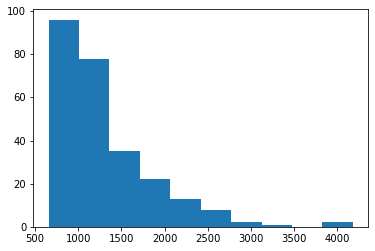

In [16]:
# Take a look at intensity distributions.
plt.hist(fits[:,3]);

In [17]:
fits_filtered = fits[fits[:,3] > 2000]
boxes = box_spots(dog_n, fits_filtered, shadows=False, halfwidth_xy=3, halfwidth_z=0)
viewer(boxes.max(axis=0), 6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…

Or you could define some kind of circularity criterion, such as the ratio of x and y widths (should be close to 1 for true circles):

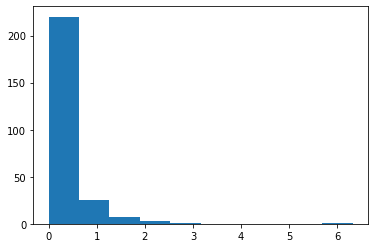

In [18]:
circularity = abs(np.log(fits[:,5] / fits[:,6]))
plt.hist(circularity);

It looks like most of them are low (perfect circles would be 0), but there are a few outliers. Let's see what these are:

In [19]:
# Where are objects that are NOT circular.
fits_filtered = fits[circularity > 1]
boxes = box_spots(dog_n, fits_filtered, shadows=False, halfwidth_xy=3, halfwidth_z=0)
viewer(boxes.max(axis=0), 6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…

Aha! Those do indeed seem to not be spots. So that's something...

For my MS2 stuff, I've been using a "peakiness" measure defined as the ratio of the intensity to the width of the gaussian fit (this is the 3D equivalent of taking the height to width ratio of a 1D gaussian curve). Dunno if this is a good approach here, but I'd just play around, generally.

In [20]:
peakiness = np.log(fits[:,3] / np.mean(fits[:,5:7], axis=1))
fits_filtered = fits[peakiness > 5.5]
viewer(box_spots(dog_n.astype('uint16'), fits_filtered, shadows=False, halfwidth_xy=3, halfwidth_z=0).max(axis=0), 6)
#viewer(box_spots(dog_n.astype('uint16'), fits_filtered, shadows=False, halfwidth_xy=3, halfwidth_z=0), 6)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'plasma', 'Reds', 'magma', 'viri…